In [1]:
# Importing all usefull libraries for this notebook
import numpy as np
import gravmag as gmc
import datafiltering as df
import matplotlib.pyplot as plt

In [2]:
def cc(data1, data2):
    '''
    Returns the crosscorrelation coefficient between two data 
    sets, which can N-dimensional. It is important that both 
    data sets have the same dimension
    '''
    m1, m2 = data1.mean(), data2.mean()
    dim1, dim2 = data1.ndim, data2.ndim
    #if dim1 == 2:
    #    data1 = data1.reshape(data1.size)
    #if dim2 == 2:
    #    data2 = data2.reshape(data2.size)
    
    # Formulation
    num = np.sum((data1 - m1)*(data2 - m2))
    s1 = np.sum((data1 - m1)**2)
    s2 = np.sum((data2 - m2)**2)
    cc = num/np.sqrt(s1*s2)
    
    return cc

In [3]:
# Defines number of points
x = np.linspace(-1000, 1000, 200)
y = x
z = -10.#np.random.normal(loc = -10., scale = 0.5, size = x.size)

# Creates the grid
X, Y = np.meshgrid(x, y)

modelgrav = (-100., 100., -100., 100., 20., 120., 2300.)
modelmag = (-100., 100., -100., 100., 20., 120., 2.3)

In [4]:
# Computes the potential data
gz = gmc.prism_gz(X, Y, z, modelgrav)
tf = gmc.prism_tf(X, Y, z, modelmag, [35., 22.], [-45., 30])

In [6]:
# Create the intervals for inclination and declination
inc = np.linspace(10., 90., 100)
dec = np.linspace(-180., +180., 150)

ni, nd = inc.size, dec.size
# Create the grid
Dec, Inc = np.meshgrid(dec, inc)

In [7]:
# Create the array to allocate the result
res1 = np.zeros([ni, nd])
res2 = np.zeros([ni, nd])
res3 = np.zeros([ni, nd])
for j in range(nd):
    for i in range(ni):
        rtp = df.reduction(x, y, tf,(-45.0, 30,0), (inc[i], dec[j]), (90., 0.), (90., 0.))
        hga = df.totalgrad(x, y, rtp)
        tilt = df.tilt(x, y, rtp)
        dz = df.zderiv(x, y, rtp, 1)
        res1[i,j] = cc(rtp, hga)
        res2[i,j] = cc(rtp, tilt)
        res3[i,j] = cc(rtp, dz)

datafiltering.py:147: RuntimeWarning: invalid value encountered in true_divide
  theta = z + ((x*u + y*v)/k)*1j


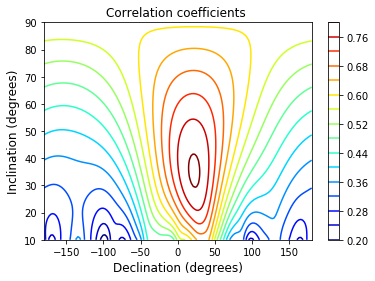

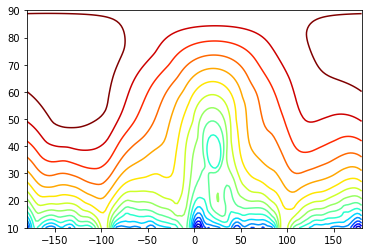

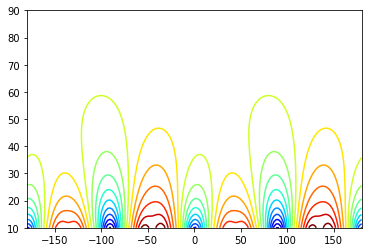

In [9]:
plt.figure()
plt.contour(Dec, Inc, res1, 20,cmap = plt.cm.jet)
plt.title('Correlation coefficients ', fontsize = 12)
plt.xlabel('Declination (degrees)',fontsize = 12)
plt.ylabel('Inclination (degrees)',fontsize = 12)
plt.colorbar()
plt.show()

plt.figure()
plt.contour(Dec, Inc, res2, 20,cmap = plt.cm.jet)
plt.colorbar
plt.show()

plt.figure()
plt.contour(Dec, Inc, res3, 20,cmap = plt.cm.jet)
plt.show()